In [80]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

%matplotlib inline
plt.style.use('seaborn-whitegrid')
torch.set_printoptions(edgeitems=2)

In [81]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

## Linear Regression with Matrix
&nbsp; 현재 사용하는 예시는 변수가 하나인 경우이기에 큰 차이를 느낄 수 없지만, 변수가 여러 개이고 데이터의 수가 많을 때 행렬을 사용하면 더욱 편리하고 성능 면에서도 더 뛰어난 모형을 만들 수 있다.


In [82]:
# change array into matrix
def matrix_feature(x_in, deg=5):
    """
        x_in: N x 1 tensor
        return: N x (deg+1) tensor
    """
    print('x_in: ', x_in.shape)
    z = torch.empty(x_in.shape[0], deg)
    for i, x in enumerate(x_in):
        z[i, :] = torch.tensor([np.power(x, n) for n in range(1,deg+1)])
    return z

In [83]:
z_c = matrix_feature(t_c, deg=1)
z_u = matrix_feature(t_u, deg=1)

x_in:  torch.Size([11])
x_in:  torch.Size([11])


In [84]:
def model(t_u, w, b):
    return w * t_u + b

In [85]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

## Tensor of Auto Grad
&nbsp; `requires_grad` 속성을 `True` 로 설정하면, 해당 tensor에서 이뤄진 모든 연산들을 추적(track)하기 시작한다. 계산이 완료된 후 `backward()` 를 호출하여 모든 gradient를 자동으로 계산할 수 있다. 이 Tensor의 변화도는 `grad` attribute에 누적된다.

In [86]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
params

tensor([1., 0.], requires_grad=True)

In [87]:
pred = model(t_u, *params)
loss = loss_fn(pred, t_c)
loss.backward() 

print('dloss/dparam = ', params.grad)

dloss/dparam =  tensor([4517.2969,   82.6000])


In [88]:
loss, loss.data, loss.grad, loss.grad_fn

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


(tensor(1763.8846, grad_fn=<MeanBackward0>),
 tensor(1763.8846),
 None,
 <MeanBackward0 at 0x7faaf8103c18>)

&nbsp; 기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해, 코드 블럭을 `with torch.no_grad():` 로 감쌀 수 있다. 이는 특히 gradient는 필요하지 않지만, `requires_grad=True` 가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용하다.

In [89]:
print(params.requires_grad)
print((params**2).requires_grad)

with torch.no_grad():
    print((params**2).requires_grad)

True
True
False


 &nbsp; `detach()` 를 호출하여 내용물(content)은 같지만 require_grad가 다른 새로운 Tensor를 가져올 수 있다. Tensor가 기록을 추적하는 것(메모리를 사용하는 것)을 방지할 수 있다.




In [90]:
print(params.requires_grad)
y = params.detach()
print(y.requires_grad)
print(params.eq(y).all())

True
False
tensor(True)


&nbsp; 파이토치에서는 backpropagation을 시작하기 전에 gradient를 0으로 설정해주는데, 이는 backpropagation 이전에 `backward()`를 호출하면서 gradient를 누적했기 때문이다. 

In [91]:
if params.grad is not None:  
    params.grad.zero_()

In [92]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad(): 
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [93]:
params = training_loop(n_epochs = 3000, 
                       learning_rate = 1e-2, 
                       params = torch.tensor([1.0, 0.0], requires_grad=True), # <1> 
                       t_u = t_un, # <2> 
                       t_c = t_c)

params

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648


tensor([  5.3489, -17.1980], requires_grad=True)

In [94]:
tlin = torch.linspace(0, 90)
with torch.no_grad():
    t_p = params[0] * tlin *0.1 + params[1]

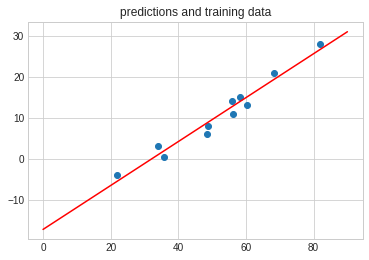

In [95]:
plt.plot(tlin, t_p, 'r-')
plt.scatter(t_u, t_c)
plt.title('predictions and training data');

## Optimizers

&nbsp; 지금까지는 autograd의 추적 기록을 피하기 위해 `torch.no_grad ()`를 사용하여 학습 가능한 매개변수를 갖는 Tensor를 직접 조작하며 모델의 가중치를 갱신했다. 이것은 확률적 경사 하강법(SGD)과 같은 간단한 최적화 알고리즘에서는 크게 부담이 되지는 않지만, 실제로 신경망을 학습할 때는 주로 AdaGrad, RMSProp, Adam 등과 같은 좀 더 정교한 Optimizer를 사용한다.



In [96]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2

optimizer = optim.SGD([params], lr=learning_rate) # stochastic

In [97]:
# 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산
t_p = model(t_u, *params)

# 손실을 계산하고 출력
loss = loss_fn(t_p, t_c)

# 역전파 단계: 모델의 매개변수에 대한 손실의 변화도를 계산
loss.backward()

# optimizer의 step 함수를 호출하면 parameter가 갱신된다.
optimizer.step()

params, params.grad

(tensor([-44.1730,  -0.8260], requires_grad=True),
 tensor([4517.2969,   82.6000]))

In [98]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [99]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [100]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params, # <1> 
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860118
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927680
Epoch 4500, Loss 2.927651
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012], requires_grad=True)

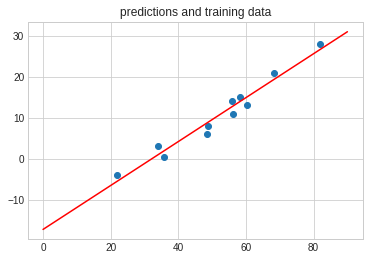

In [101]:
tlin = torch.linspace(0, 90)
with torch.no_grad():
    t_p = params[0] * tlin *0.1 + params[1]
    
plt.plot(tlin, t_p, 'r-')
plt.scatter(t_u, t_c)
plt.title('predictions and training data');

### Adam instead of SGD

In [102]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_un, 
    t_c = t_c)

Epoch 500, Loss 2.962302
Epoch 1000, Loss 2.927647
Epoch 1500, Loss 2.927646
Epoch 2000, Loss 2.927646
Epoch 2500, Loss 2.927646
Epoch 3000, Loss 2.927646
Epoch 3500, Loss 2.927646
Epoch 4000, Loss 2.927645
Epoch 4500, Loss 2.927644
Epoch 5000, Loss 2.927645


tensor([  5.3677, -17.3048], requires_grad=True)

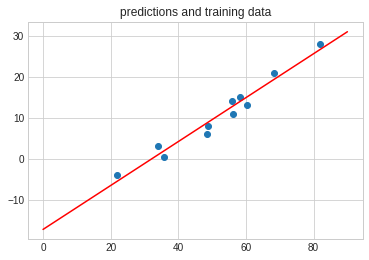

In [103]:
tlin = torch.linspace(0, 90)
with torch.no_grad():
    t_p = params[0] * tlin *0.1 + params[1]
    
plt.plot(tlin, t_p, 'r-')
plt.scatter(t_u, t_c)
plt.title('predictions and training data');